# Analysis and Downstream Tasks

This section runs all downstream analyses, including:
- TVD (Total Variation Distance) calculations  
- MSE and MAE error metrics  
- CellTypist cell type predictions  
- Differential expression analysis  


## 1. MSE and MAE error metrics

#### Compute bulk MAE/MSE between naive and ground truth and also predicted vs ground truth 

In [2]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j)  4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # Ground truth UMI length (adata_12)
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")

# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model approach (UMI lengths 1-12)
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"


model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/"
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (example adata_dict_model[6]):")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset (example adata_dict_naive[6]):")
print(adata_dict_naive[6])

# --- Compute Bulk MAE for the Model Approach ---
# Use ground truth counts from adata_12 and predicted counts from the model (inverted) dataset at UMI length j.
all_true_model = []
all_pred_model = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the model dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_model = adata_dict_model[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        pred_counts = gene_counts_model[mask] 
        
        all_true_model.extend(true_counts)
        all_pred_model.extend(pred_counts)

all_true_model = np.array(all_true_model)
all_pred_model = np.array(all_pred_model)
bulk_mae_model = calculate_mae(all_true_model, all_pred_model)
bulk_mse_model = calculate_mse(all_true_model, all_pred_model)
# print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)


# --- Compute Bulk MAE for the Naive Approach ---
# Use ground truth counts from adata_12 and predicted counts from the naive dataset at UMI length j.
all_true_naive = []
all_naive_pred = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the naive dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_naive = adata_dict_naive[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        naive_counts = gene_counts_naive[mask] 
        
        all_true_naive.extend(true_counts)
        all_naive_pred.extend(naive_counts)

all_true_naive = np.array(all_true_naive)
all_naive_pred = np.array(all_naive_pred)
bulk_mae_naive = calculate_mae(all_true_naive, all_naive_pred)
bulk_mse_naive = calculate_mse(all_true_naive, all_naive_pred)


print("Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mae_naive)
print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)
percent_change = (bulk_mae_naive - bulk_mae_model)/ bulk_mae_naive
print("Percent Change", percent_change * 100)
print("=======================================================================")

print("Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mse_naive)
print("Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mse_model)
percent_change = (bulk_mse_naive - bulk_mse_model)/ bulk_mse_naive 
print("Percent Change", percent_change * 100)


Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (example adata_dict_model[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset (example adata_dict_naive[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5): 0.10638695235109294
Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5): 0.05002175747142818
Percent Change 52.98130422389688
Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5): 155.43933026750406
Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5): 7.384367536213194
Percent Change 95.24935708130945


#### Per-cell MAE and MSE: Naïve vs Model (scatter comparison)

Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (inverted), example adata_dict_model[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset, example adata_dict_naive[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Per-cell Model MAE Vector:
[0.04241276 0.034528   0.02913269 ... 0.03987178 0.03798206 0.03595877]
Per-cell Model MSE Vector:
[0.08315598 0.09229154 0.07698606 ... 0.34494497 0.07738931 0.05792321]
Per-cell Naive MAE Vector:
[0.06495726 0.04389258 0.03994294 ... 0.05747532 0.05554296 0.04065621]
Per-cell Naive MSE Vector:
[0.61733822 0.56020791 0.82239658 ... 1.95803949 0.4676944  0.2211127 ] 1232
Percent of cells where MSE_Model is better than Naive: 99.43%


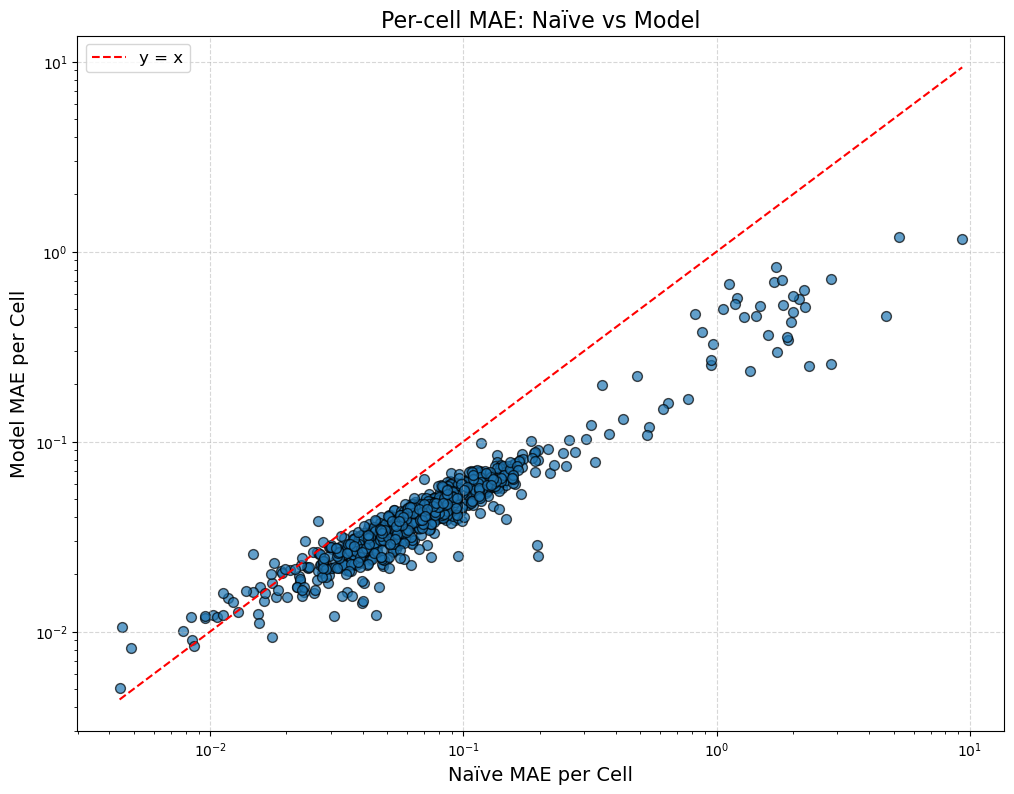

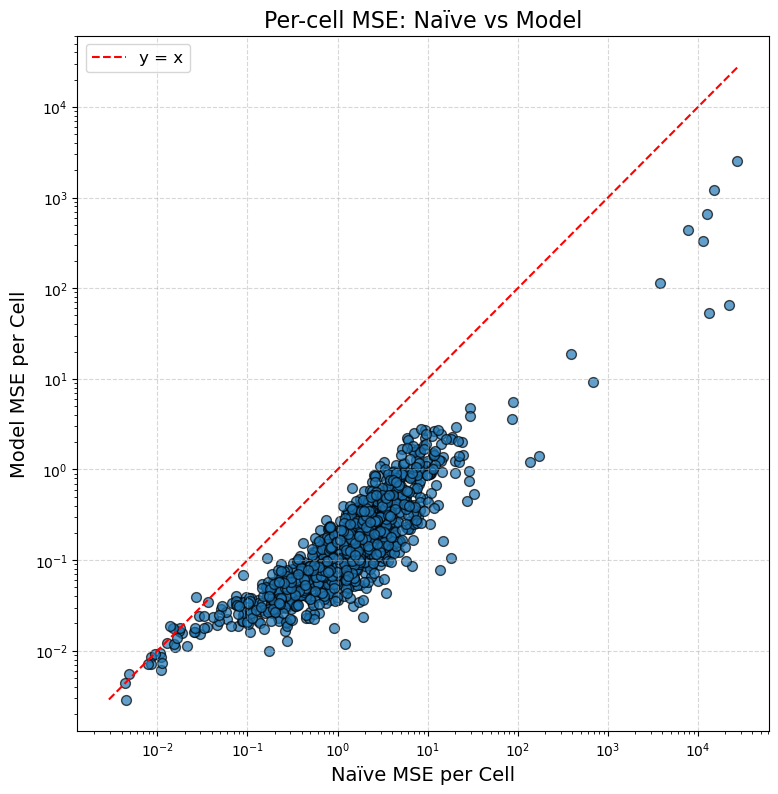

In [3]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # UMI length for ground truth
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad") #1k
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad") #10k
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model MAE and MSE (UMI lengths 1-12)
model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/" #10k
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (inverted), example adata_dict_model[6]:")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/" #1k
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/" # 10k
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset, example adata_dict_naive[6]:")
print(adata_dict_naive[6])

# --- Compute Per-cell MAE for the Model Approach ---
mae_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mae_model_vector.append(calculate_mae(true_counts, predicted_counts))
mae_model_vector = np.array(mae_model_vector)
print("Per-cell Model MAE Vector:")
print(mae_model_vector)

# --- Compute Per-cell MSE for the Model Approach ---
mse_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mse_model_vector.append(calculate_mse(true_counts, predicted_counts))
mse_model_vector = np.array(mse_model_vector)
print("Per-cell Model MSE Vector:")
print(mse_model_vector)

# --- Compute Per-cell MAE for the Naive Approach ---
naive_mae_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mae_vector.append(calculate_mae(true_counts, naive_counts))
naive_mae_vector = np.array(naive_mae_vector)
print("Per-cell Naive MAE Vector:")
print(naive_mae_vector)

# --- Compute Per-cell MSE for the Naive Approach ---
naive_mse_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mse_vector.append(calculate_mse(true_counts, naive_counts))
naive_mse_vector = np.array(naive_mse_vector)
print("Per-cell Naive MSE Vector:")
print(naive_mse_vector, len(naive_mse_vector))


# --- Calculate Percent of Cells where MSE_Model is Better than MSE_Naive ---
better_model_count = np.sum(mse_model_vector < naive_mse_vector)
total_cells = len(mse_model_vector)
percent_better_model = (better_model_count / total_cells) * 100

print(f"Percent of cells where MSE_Model is better than Naive: {percent_better_model:.2f}%")




import matplotlib.pyplot as plt

# --- MAE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mae_vector, mae_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MAE per Cell", fontsize=14)
plt.ylabel("Model MAE per Cell", fontsize=14)
plt.title("Per-cell MAE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mae_vector.min(), mae_model_vector.min())
max_val = max(naive_mae_vector.max(), mae_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MAE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mae_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mae_naive_vs_model.pdf")
plt.show()

# --- MSE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mse_vector, mse_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MSE per Cell", fontsize=14)
plt.ylabel("Model MSE per Cell", fontsize=14)
plt.title("Per-cell MSE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mse_vector.min(), mse_model_vector.min())
max_val = max(naive_mse_vector.max(), mse_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MSE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mse_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mse_naive_vs_model.pdf")
plt.show()


## 2. TVD

#### All genes

[0.3368852001722949, 0.21176016361166244, 0.10595201467199507, 0.04465060728021486, 0.017968891065187446, 0.007860886158858675, 0.004016777441768168, 0.0024429705490248517, 0.0016631036278363723, 0.0010247961546732093, 0.00038425499939834576, 0.0]
[0.2846129458250203, 0.10970751580117084, 0.04026084059723804, 0.019702735930069683, 0.009760108038236324, 0.005405813366971701, 0.0033586245417196042, 0.0022919765335257976, 0.0016310172085561353, 0.0010198287254215707, 0.000384253151749912, 9.190439373920128e-07]
[0.2889504819215407, 0.1055309611582611, 0.03666628821529145, 0.017400471023131543, 0.008661108811398088, 0.004997525913480286, 0.0032319155623733897, 0.0022601534705541733, 0.0016250485787615483, 0.0010192020102711375, 0.0003843783916711162, 0.0]


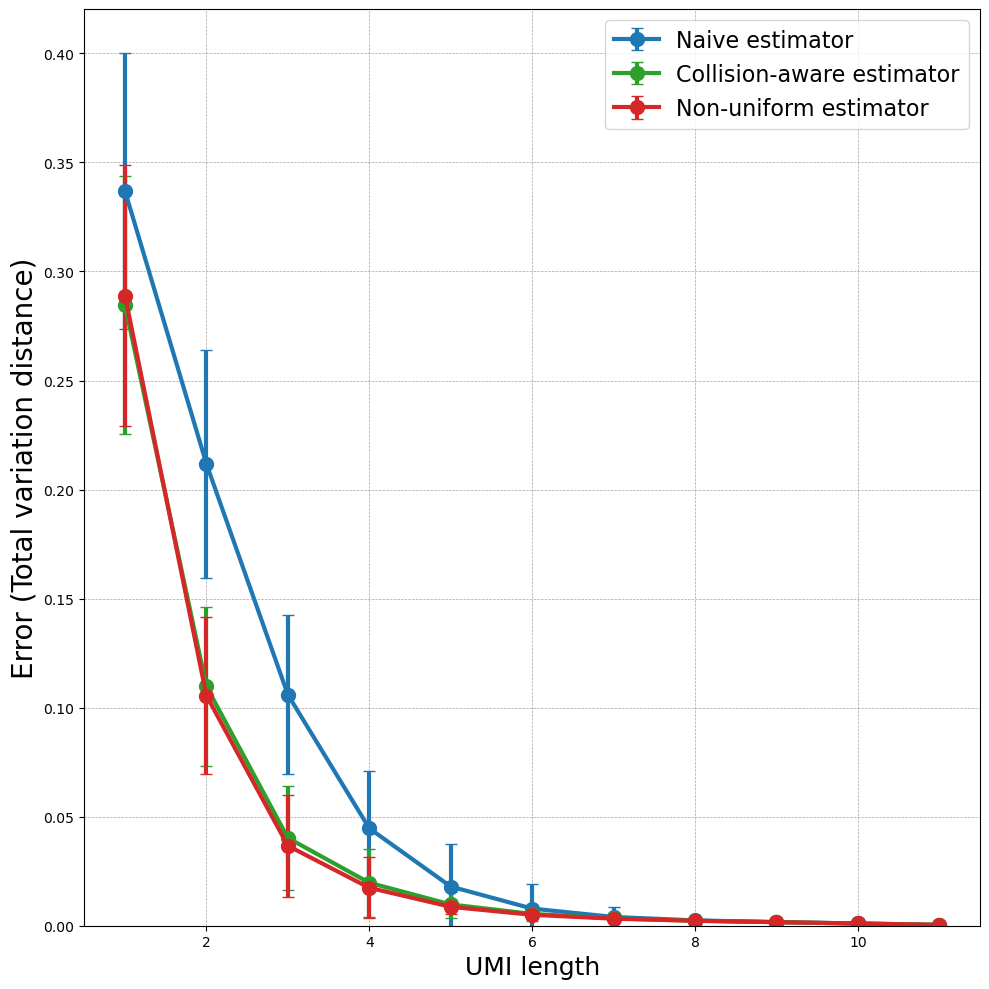

In [11]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted unif matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices" 
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    unif_adata_dict[i] = sc.read_h5ad(path)
    
# Loadin the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    non_unif_adata_dict[i] = sc.read_h5ad(path)
non_unif_adata_dict[12] = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts_gt >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for unif_matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts_gt >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts_gt >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()

#### All genes, MALAT1

[0.3245063090841096, 0.19813572304361782, 0.0938038065659219, 0.0370260266665543, 0.014703074521474343, 0.006759437175835562, 0.0037195522253422693, 0.002396582346403479, 0.0016720546536448564, 0.0010380263452730108, 0.0003920022840447437, 0.0]
[0.2716234409172259, 0.09709532104435861, 0.03515776761366962, 0.01670218713808766, 0.00848156200293026, 0.004955192904770617, 0.003239867966329156, 0.002284003117814455, 0.0016465993303931158, 0.001033967061862571, 0.0003920246400758106, 7.598200627767585e-07]
[0.27592121294839544, 0.09302549555737695, 0.03259752006512591, 0.015122255823627277, 0.007707704285966329, 0.00466053719055167, 0.003145317539128239, 0.002259666292473848, 0.001642263151342991, 0.0010336253561135616, 0.00039215804222064867, 0.0]


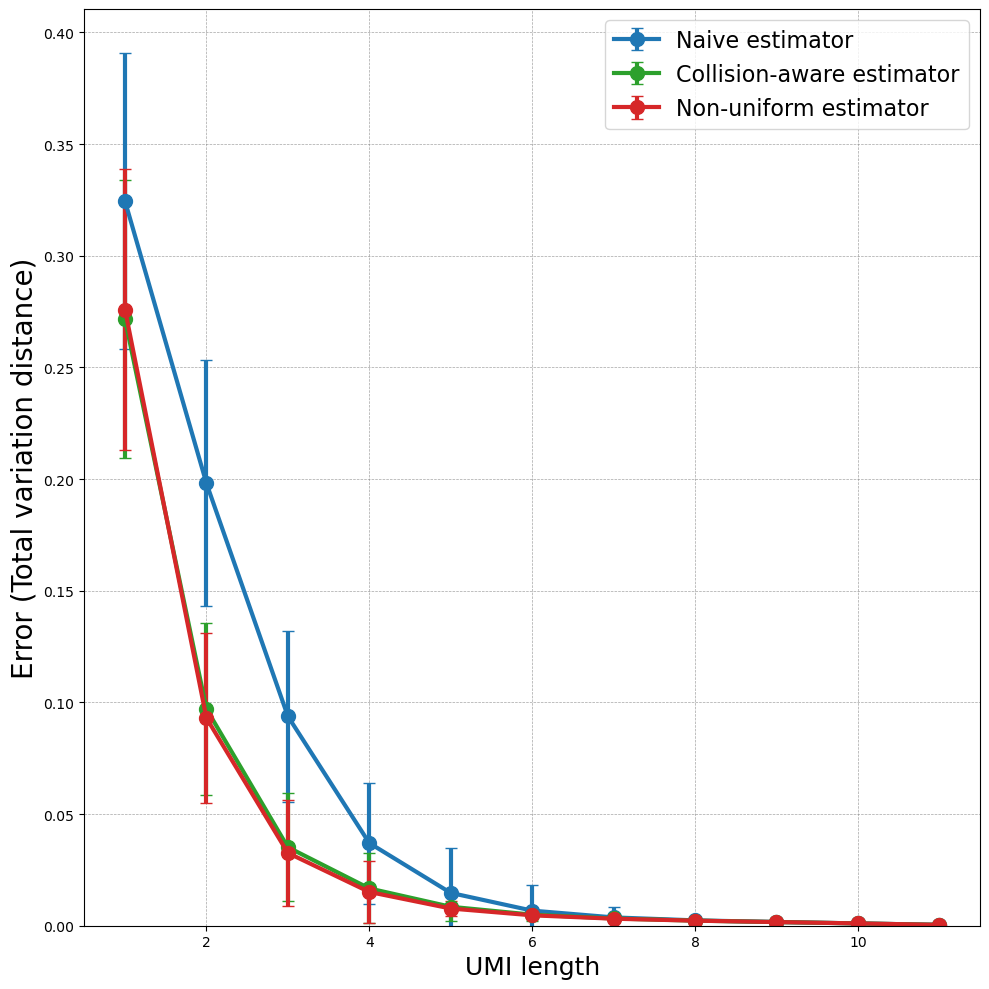

In [12]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

remove = np.array(['MALAT1'])  # <-- replace with your list

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# Loading the inverted unif matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    unif_adata_dict[i] = adata

# Loading the inverted non-unif matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata
# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []
mean_errors3 = []
std_errors3 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts_gt >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for unif_matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts_gt >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))
    
    errors3 = []
    for barcode in gt_adata12.obs_names:
        index3 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts3 = non_unif_adata_dict[i].X[index3]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts3, np.ndarray):
            gene_counts3 = gene_counts3.toarray().flatten()
        else:
            gene_counts3 = gene_counts3.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts3
        mask = gene_counts_gt >= 1
        gene_counts3 = gene_counts3[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts3)
        sorted_gene_counts3 = gene_counts3[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error3 = tvd(sorted_gene_counts3, sorted_gene_counts_gt)
        errors3.append(error3)  
        
    mean_errors3.append(np.mean(errors3))
    std_errors3.append(np.std(errors3))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)


# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='o-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware estimator'
)

plt.errorbar(
    range(1, num_experiments), 
    mean_errors3[:-1], 
    yerr=std_errors3[:-1], 
    fmt='o-', 
    color='#d62728',        # Red for Non-uniform Estimator
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf") #1k PBMCs
# # plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/10k_PBMCs/10k_tvd_plot.pdf") #10k PBMCs
plt.show()

## 3. Differential expression analysis

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

#### Step 1: Load the adata matrices, load labels from celltypist

In [ ]:
# Load data31
j = 5
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5


assert adata_12.obs_names.equals(adata_naive.obs_names), "Cell barcodes differ!"
assert adata_12.var_names.equals(adata_naive.var_names), "Genes differ!"


# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()


gene = 'CD14_mono' ### change gene name
# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: gene if x == gene else 'Other cells')
print(binary_labels)


#### Step 2: Pre-processing datasets

In [ ]:

adata_12.raw  = adata_12.copy()
adata_naive.raw = adata_naive.copy()
adata_pred.raw  = adata_pred.copy()

# sc.pp.highly_variable_genes(adata_12, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)

# Repeat for naive and pred
# sc.pp.highly_variable_genes(adata_naive, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

# sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_pred, target_sum=1e4) 
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)

    
    
# print("This is the matrix for adata_12", adata_12.X)
# print("This is the matrix for adata_naive", adata_naive.X)
# print("This is the matrix for adata_pred", adata_pred.X)


### Step 3: Run DE using t-test

- The following command compares gene expression between one cluster and all other clusters, across all genes, to find the most distinctly expressed genes

- For each gene and each cluster, scanpy computes log fold change, p-value, adj p-value, scores for ranking genes \n

- Tell you which genes are significanty more (or less) expressed in one cluster compared to the others

In [ ]:
method = 'wilcoxon'  # Using t-test for differential expression analysis
sc.tl.rank_genes_groups(
    adata_12,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_naive,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_pred,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)

### Step 5: Extract DE results for one cluster

- extracting differential gene expression results for  specific cluster after running rank_gene_groups 
- The function below returns a pandas dataframe containing the ranked list of differentially expressed genes from a specific group clsuter
- group 1: You're pulling the DE genes where cluster "1" is compared against all the other clusters (one vs. rest)
- key = "t-test": You'res saying, "Give me the results from the DE analysis that used the t-test method
- de_12 = DE genes for cluster 1 using ground truth UMI-12 counts 
- de_5 = DE genes for cluster 1 using naive UMI-5 counts 
- de_5_pred: DE genes for cluster 1 usig predicited UMI-5 counts 

In [ ]:
# gene = 'CD4.Naive'  # The gene of interest for differential expression analysis
de_12 = sc.get.rank_genes_groups_df(adata_12, group=gene, key=method)
de_naive = sc.get.rank_genes_groups_df(adata_naive, group=gene, key=method)
de_pred = sc.get.rank_genes_groups_df(adata_pred, group=gene, key=method)
print(de_12.head(10))
print("==================================")
print(de_naive.head(10))
print("==================================")
print(de_pred.head(10))
assert(len(de_12)) == len(de_naive) == len(de_pred), "Number of DE genes differ across datasets!"

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sp


adata_gt = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
# 1) Compute average counts per gene from adata_12
X12 = adata_gt.X
if sp.issparse(X12):
    avg12 = np.asarray(X12.mean(axis=0)).ravel()
else:
    avg12 = X12.mean(axis=0)

df_avg12 = pd.DataFrame({
    "gene": adata_gt.var_names,
    "avg_count": avg12
})

# 2) Merge into new DE DataFrames (preserving original de_* unmodified)
de_12_avg    = de_12   .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")

# 3) Inspect
print("Ground truth DE + avg:\n",    de_12_avg   .head(), "\n")
print("Naive DE + avg:\n",           de_naive_avg.head(), "\n")
print("Predicted DE + avg:\n",       de_pred_avg .head(), "\n")
print(len(de_12_avg), len(de_naive_avg), len(de_pred_avg))


#### Step 6: Differential expression alignment: log-FC shifts vs. UMI-12 (naïve vs predicted)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter genes from UMI-12 results
fc_hi = 0.32
fc_lo = -0.32
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'

keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= fc_hi) | (de_12_avg['logfoldchanges'] <= fc_lo)) &
    (de_12_avg[pcol] < 0.05) &
    (de_12_avg['avg_count'] >= 10),
    'names'
]

# Keep only these genes in all datasets
de_12_avg    = de_12_avg[de_12_avg['names'].isin(keep_genes)]
de_naive_avg = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
de_pred_avg  = de_pred_avg[de_pred_avg['names'].isin(keep_genes)]

# Merge results into one dataframe
df = (
    de_12_avg[['names', 'logfoldchanges', 'avg_count']].rename(columns={'logfoldchanges': 'lfc_12'})
      .merge(
          de_naive_avg[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_naive'}),
          on='names'
      )
      .merge(
          de_pred_avg[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_pred'}),
          on='names'
      )
)

# Sort by abundance
df = df.sort_values('avg_count').reset_index(drop=True)

# Calculate log-FC differences from UMI-12
df["logrf_naive"] = df['lfc_naive'] - df['lfc_12']
df["logrf_pred"]  = df['lfc_pred']  - df['lfc_12']

# Sum of squared differences
sum_squared_naive = (df['logrf_naive'] ** 2).sum()
sum_squared_pred  = (df['logrf_pred']  ** 2).sum()

print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_squared_naive:.3f}")
print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_squared_pred:.3f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Naive vs ground truth
axes[0].scatter(df['avg_count'], df['logrf_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(lfc_12 / lfc_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'Log-FC shift: Ground truth vs Naïve, UMI {j}')

# Predicted vs ground truth
axes[1].scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'Log-FC shift: Ground truth vs Predicted, UMI {j}')

plt.tight_layout()
plt.show()


#### Step 8: Big loop for entire pipeline for all k in order to generate cumulative plot

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config
# -------------------------
UMI_MIN, UMI_MAX = 1, 13     # will skip any missing j via try/except
GENE_LABEL = 'CD14_mono'
METHOD = 'wilcoxon'
FC_HI = np.log2(1.25)        # ≈ 0.32
FC_LO = -np.log2(1.25)       # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

GT_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED_FMT  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad"

OUT_PDF  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.pdf"
OUT_CSV  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.csv"

# -------------------------
# Ground truth + labels (once)
# -------------------------
adata_gt = sc.read_h5ad(GT_PATH)
labels = sc.read_h5ad(LAB_PATH)
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: GENE_LABEL if x == GENE_LABEL else 'Other cells')

# normalized GT copy for DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs['label'] = binary_labels.loc[adata_12_norm.obs_names]

# GT DE
sc.tl.rank_genes_groups(
    adata_12_norm,
    groupby='label',
    method=METHOD,
    key_added=METHOD,
    use_raw=False
)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=GENE_LABEL, key=METHOD)

# avg counts from *raw* GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# attach avg to GT DE
de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# filter genes based on GT only
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'
keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= FC_HI) | (de_12_avg['logfoldchanges'] <= FC_LO))
    & (de_12_avg[pcol] < PVAL_THRESH)
    & (de_12_avg['avg_count'] >= AVG_COUNT_MIN),
    'names'
].astype(str).values


# Storage
ks = []
mse_naive, mse_pred = [], []
err_lo_naive, err_hi_naive = [], []
err_lo_pred,  err_hi_pred  = [], []
sse_naive, sse_pred = [], []

# Loop UMI lengths
for j in range(UMI_MIN, UMI_MAX + 1):
    naive_path = NAIVE_FMT.format(j=j)
    pred_path  = PRED_FMT.format(j=j)
    if not (Path(naive_path).exists() and Path(pred_path).exists()):
        continue  # skip gracefully if either file is missing

    adata_naive = sc.read_h5ad(naive_path)
    adata_pred  = sc.read_h5ad(pred_path)

    # alignment checks
    assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
    assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
    assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
    assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

    # normalize/log1p & labels
    for ad in (adata_naive, adata_pred):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.obs['label'] = binary_labels.loc[ad.obs_names]

    # DE
    sc.tl.rank_genes_groups(adata_naive, groupby='label', method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby='label', method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=GENE_LABEL, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=GENE_LABEL, key=METHOD)

    # attach avg & restrict to keep_genes
    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    de_12_k    = de_12_avg   [de_12_avg['names'].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg['names'].isin(keep_genes)]

    # merge three on names
    df = (
        de_12_k[['names','logfoldchanges','avg_count']].rename(columns={'logfoldchanges':'lfc_12'})
          .merge(de_naive_k[['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_naive'}), on='names')
          .merge(de_pred_k [['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_pred'}),  on='names')
          .sort_values('avg_count')
          .reset_index(drop=True)
    )

    # per-gene squared errors
    se_naive = (df['lfc_naive'].to_numpy() - df['lfc_12'].to_numpy())**2
    se_pred  = (df['lfc_pred' ].to_numpy() - df['lfc_12'].to_numpy())**2
    # print(f"UMI-{j}: {se_naive}, {se_pred}")

    # MSE and empirical 95% quantile error bars
    mse_n = float(se_naive.mean()) if se_naive.size else np.nan
    mse_p = float(se_pred.mean())  if se_pred.size  else np.nan

    qn_low, qn_high = np.percentile(se_naive, [2.5, 97.5]) if se_naive.size else (np.nan, np.nan)
    qp_low, qp_high = np.percentile(se_pred,  [2.5, 97.5]) if se_pred.size  else (np.nan, np.nan)

    # asymmetric errors relative to the mean
    yerr_n_low = mse_n - qn_low
    yerr_n_hi  = qn_high - mse_n
    yerr_p_low = mse_p - qp_low
    yerr_p_hi  = qp_high - mse_p

    # SSE (optional, in case you want them)
    sse_n = float(se_naive.sum()) if se_naive.size else np.nan
    sse_p = float(se_pred.sum())  if se_pred.size  else np.nan
    print(f"UMI-{j}: MSE naive={mse_n}, MSE pred={mse_p}, SSE naive={sse_n}, SSE pred={sse_p}")

    # collect
    ks.append(j)
    mse_naive.append(mse_n); mse_pred.append(mse_p)
    err_lo_naive.append(yerr_n_low); err_hi_naive.append(yerr_n_hi)
    err_lo_pred.append(yerr_p_low);  err_hi_pred.append(yerr_p_hi)
    sse_naive.append(sse_n); sse_pred.append(sse_p)

In [ ]:
ks = np.array(ks)
mse_naive = np.array(mse_naive); mse_pred = np.array(mse_pred)
err_lo_naive = np.array(err_lo_naive); err_hi_naive = np.array(err_hi_naive)
err_lo_pred  = np.array(err_lo_pred);  err_hi_pred  = np.array(err_hi_pred)
sse_naive = np.array(sse_naive); sse_pred = np.array(sse_pred)

out = pd.DataFrame({
    "umi_length": ks,
    "mse_naive": mse_naive,
    "mse_pred": mse_pred,
    "mse_naive_ci2p5": mse_naive - err_lo_naive,
    "mse_naive_ci97p5": mse_naive + err_hi_naive,
    "mse_pred_ci2p5": mse_pred - err_lo_pred,
    "mse_pred_ci97p5": mse_pred + err_hi_pred,
    "sse_naive": sse_naive,
    "sse_pred": sse_pred
}).sort_values("umi_length")
Path(OUT_CSV).parent.mkdir(parents=True, exist_ok=True)
out.to_csv(OUT_CSV, index=False)

plt.figure(figsize=(10, 10))

yerr_naive = np.vstack([err_lo_naive, err_hi_naive])
yerr_pred  = np.vstack([err_lo_pred,  err_hi_pred])

plt.errorbar(ks, mse_naive, yerr=yerr_naive, fmt='-o', linewidth=3, markersize=8,
             elinewidth=3, capsize=4, label='Naive estimator', color= "#1f77b4")
plt.errorbar(ks, mse_pred,  yerr=yerr_pred,  fmt='-o', linewidth=3, markersize=8,
             elinewidth=3, capsize=4, label='Non-uniform estimator', color = "#2ca02c")

plt.xticks(ks, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (UMI length)', fontsize=18)
plt.ylabel('MSE of differences in lfc', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)
plt.legend(fontsize=16)
plt.yscale('log')
plt.ylim(bottom=1e-7)  # Adjusted y-limits for better visibility
plt.tight_layout()
plt.ylim(bottom=0)
Path(OUT_PDF).parent.mkdir(parents=True, exist_ok=True)
plt.show()

## 7. TVD Poisson Counts

In [2]:
import numpy as np
import scanpy as sc 

def closed_form_error_floor(adata):
    """Calculate the TVD error floor using closed-form approximation."""
    
    per_cell_means = []
    per_cell_vars = []
    
    for idx, _ in enumerate(adata.obs_names):
        # get counts for this cell
        row = adata.X[idx]
        x = row.toarray().ravel() if hasattr(row, "toarray") else np.asarray(row).ravel()
        
        # only consider genes with nonzero counts
        mask = x >= 1
        x = x[mask]
        
        N_c = x.sum()
        if N_c <= 0:
            continue
        
        p = x / N_c
        
        # closed-form expected TVD and variance
        expected_TV = (1 / np.sqrt(2 * np.pi * N_c)) * np.sum(np.sqrt(p * (1 - p)))
        var_TV = ((1 - 2 / np.pi) / (4 * N_c)) * np.sum(p * (1 - p))
        
        per_cell_means.append(expected_TV)
        per_cell_vars.append(var_TV)
        
    per_cell_means = np.array(per_cell_means)
    per_cell_vars = np.array(per_cell_vars)
    
    mu_bar = per_cell_means.mean()
    sigma_bar = np.sqrt(per_cell_vars.mean())
    
    return mu_bar, sigma_bar


In [3]:
import numpy as np 
import scipy.sparse as sp

def simulated_error_floor(adata, B=500, seed=42):
    """Calculate the TVD error floor using Monte Carlo sampling."""
    
    rng = np.random.default_rng(seed)
    
    per_cell_means = []
    per_cell_vars = []
    
    for idx, _ in enumerate(adata.obs_names):
        # get counts for this cell
        row = adata.X[idx]
        x = row.toarray().ravel() if sp.issparse(row) else np.asarray(row).ravel()
        
        # only consider genes with nonzero counts
        mask = x >= 1
        x = x[mask]
        
        N_c = x.sum()
        p = x / N_c
        
        # draw B samples from multinomial
        samples = rng.multinomial(N_c, p, size=B)
        
        # normalize samples to probabilities
        samples_p = samples / N_c
        
        diffs = np.abs(samples_p - p)
        tvds = 0.5 * np.sum(diffs, axis=1)
        
        per_cell_means.append(np.mean(tvds))
        
        # unbiased variance estimate (ddof=1)
        per_cell_vars.append(tvds.var(ddof=1))
        
    per_cell_means = np.array(per_cell_means)
    per_cell_vars = np.array(per_cell_vars)
    
    mu_bar = per_cell_means.mean()
    sigma_bar = np.sqrt(per_cell_vars.mean())
    
    return mu_bar, sigma_bar
  

In [5]:
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
print("Closed form error floor", closed_form_error_floor(adata_12))
print("Simulated error floor", simulated_error_floor(adata_12, B=500, seed=42))

Closed form error floor (0.1859452066378577, 0.0037450345975136258)
Simulated error floor (0.17756877909967245, 0.0038831321548337752)
